In [252]:
import sys
from enum import Enum
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,classification_report,f1_score,recall_score

In [31]:
class measurement(Enum):
    HEART_RATE = 220045
    RESPIRATORY_RATE = 220210
    O2_SATURATION = 220277
    BLOOD_PRESSURE = 220181

In [184]:
# Read the file into pandas dataframe
hypertension_patients = pd.read_csv("C:/Users/Public/Output/adult_icu/hypertension_patients.csv")

In [185]:
# Read the file into pandas dataframe
hypertension_charts = pd.read_csv("C:/Users/Public/Output/adult_icu/hypertension_charts.csv")


For measurement of HEART_RATE
AUC:  0.5216536470428943
F1 Score 0.0


C:\Users\manis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


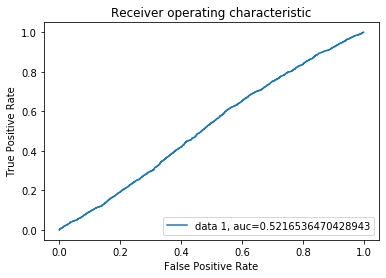

-------------------------------------------------------------------------------
For measurement of RESPIRATORY_RATE
AUC:  0.5270621743398866
F1 Score 0.0021329541414859578


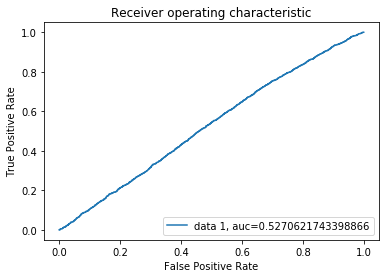

-------------------------------------------------------------------------------
For measurement of O2_SATURATION
AUC:  0.49689852419841085
F1 Score 0.0


C:\Users\manis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


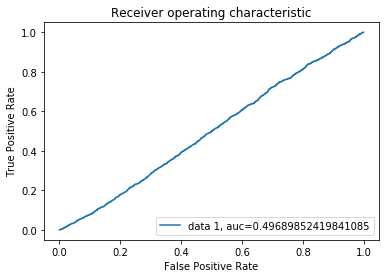

-------------------------------------------------------------------------------
For measurement of BLOOD_PRESSURE
AUC:  0.5254656624455121
F1 Score 0.059080228264518295


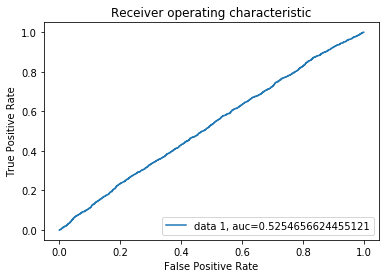

-------------------------------------------------------------------------------


In [251]:
for values in measurement:

    #filtering in only required measurement  values  values.value
    msr_val = hypertension_charts [hypertension_charts['itemid'] == values.value]

    #filtering out heart_rate values having count <2
    rm_ptnt = msr_val.groupby(['subject_id','hadm_id'],as_index = False).valuenum.agg(['count']).reset_index() 
    rm_ptnt = rm_ptnt.loc[rm_ptnt['count']<2]
    msr_val = msr_val.loc[~(msr_val['subject_id'].isin(rm_ptnt['subject_id']) & rm_ptnt['hadm_id'].isin(rm_ptnt['hadm_id']))]


    #finding min, max, mean of measurement vales based on subject_id and hadm_id
    new_df_val = pd.core.frame.DataFrame(msr_val.groupby(['subject_id','hadm_id']).valuenum.agg(['mean','max','min'])).reset_index()

    #joining to merge features and output data
    new_df_val = pd.merge(new_df_val, hypertension_patients,  how='inner', on=['subject_id','hadm_id'])

    #drop columns that are not required
    new_df_val= new_df_val.drop(['subject_id','hadm_id'],axis=1)

    #splitting data into test and train
    df_test,df_train = new_df_val.loc[new_df_val['train'] == 0],new_df_val.loc[new_df_val['train'] == 1]
    X_train,X_test = df_train.drop(['hypertension','train'],axis=1),df_test.drop(['hypertension','train'],axis=1)
    Y_train,Y_test = df_train[['hypertension']].values.squeeze(),df_test[['hypertension']].values.squeeze()

        
    #specify the model 
    logreg = LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear',random_state=0, C=1)
    logreg.fit(X_train,Y_train)
    Y_pred = logreg.predict(X_test)
    Y_test_prob = logreg.predict_proba(X_test)
    print("For measurement of "+ values.name)
    print("AUC: ",roc_auc_score(Y_test,Y_test_prob[:,1]))
    print("F1 Score",f1_score(Y_test,Y_pred))
    
    #ROC Curve
    fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_test_prob[:,1])
    auc = metrics.roc_auc_score(Y_test, Y_test_prob[:,1])
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print("-------------------------------------------------------------------------------")